In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import pandas as pd
import torch
from dnafiber.correction.data import DNADataset
import timm
from torchmetrics import Accuracy, F1Score, CohenKappa, Precision, Recall, Specificity, MetricCollection, AUROC
from tqdm.auto import tqdm

/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
root_imgs = Path("/home/clement/Documents/data/DNAFiber/DNAICorrection/Input/")
root_prediction = Path(
    "/home/clement/Documents/data/DNAFiber/DNAICorrection/Output/DNAICorrection/export/multiclass/local/"
)
root_df = Path(
    "/home/clement/Documents/data/DNAFiber/DNAICorrection/classification.csv"
)

dataset = DNADataset(
    root_images=root_imgs, root_predictions=root_prediction, root_csv=root_df
)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])


train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=4,
    pin_memory=True
)

/home/clement/Documents/Projets/DeepFiberQ/dnafiber/correction/data.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Quality" : {pd.NA: 0.0, "Bad": 1.0, "Good":0.0}}, inplace=True)


In [3]:
metrics = MetricCollection(
    [
        Accuracy(num_classes=2, task="binary"),
        F1Score(num_classes=2, task="binary"),
        CohenKappa(num_classes=2, task="binary"), 
        Precision(num_classes=2, task="binary"),
        Recall(num_classes=2, task="binary"),
        Specificity(num_classes=2, task="binary"),
        AUROC(num_classes=2, task="binary")
    ]
)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10], device="cuda" if torch.cuda.is_available() else "cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_one_epoch(model, dataloader, optimizer, criterion, device, current_epoch=0):
    model.train()
    total_loss = 0.0
    for imgs, preds, labels in tqdm(dataloader, desc=f"Epoch {current_epoch+1}"):
        imgs = imgs.to(device)
        preds = preds.to(device).unsqueeze(1)
        imgs = torch.cat((imgs, preds), dim=1)  # Concatenate images and predictions along the channel dimension
        labels = labels.to(device).unsqueeze(1)  # Ensure labels are of shape (batch_size, 1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, metrics, device):
    model.eval()
    metrics.reset()
    with torch.no_grad():
        for imgs, preds, labels in dataloader:
            imgs = imgs.to(device)
            preds = preds.to(device)
            imgs = torch.cat((imgs, preds.unsqueeze(1)), dim=1)
            labels = labels.to(device)
            outputs = model(imgs).sigmoid()
            metrics.update(outputs, labels.unsqueeze(1))
    return metrics.compute()


In [4]:
torch.cuda.is_available()

True

In [7]:
def train():
    N_EPOCHS = 100
    model = timm.create_model( 'efficientnet_b5', pretrained=True, num_classes=1, in_chans=4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=1e-6)
    model.train()
    model.to(device)
    metrics.to(device)
    ref_metric = "BinaryCohenKappa"
    best_score = -1.0
    ckpt = None
    for epoch in range(N_EPOCHS):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device, current_epoch=epoch)
        metrics_result = evaluate(model, test_dataloader, metrics, device)
        current_score = metrics_result[ref_metric].item()
        if current_score > best_score:
            print(f"Epoch {epoch+1}/{N_EPOCHS}, Loss: {train_loss:.4f}")
            # Format and print metrics
            metrics_str = ", ".join([f"{name}: {value:.4f}" for name, value in metrics_result.items()])
            print(f"Metrics: {metrics_str}")
            best_score = current_score
            ckpt = model.state_dict()
        scheduler.step()
train()

Epoch 1: 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]


Epoch 1/100, Loss: 22.7659
Metrics: BinaryAccuracy: 0.2500, BinaryF1Score: 0.3943, BinaryCohenKappa: -0.0020, BinaryPrecision: 0.2463, BinaryRecall: 0.9881, BinarySpecificity: 0.0078, BinaryAUROC: 0.4898


Epoch 3: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]


Epoch 3/100, Loss: 3.8120
Metrics: BinaryAccuracy: 0.3118, BinaryF1Score: 0.3842, BinaryCohenKappa: -0.0011, BinaryPrecision: 0.2466, BinaryRecall: 0.8690, BinarySpecificity: 0.1289, BinaryAUROC: 0.5137


Epoch 6: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]


Epoch 6/100, Loss: 2.2146
Metrics: BinaryAccuracy: 0.2559, BinaryF1Score: 0.3990, BinaryCohenKappa: 0.0058, BinaryPrecision: 0.2493, BinaryRecall: 1.0000, BinarySpecificity: 0.0117, BinaryAUROC: 0.5484


Epoch 7: 100%|██████████| 11/11 [00:02<00:00,  4.26it/s]


Epoch 7/100, Loss: 1.8293
Metrics: BinaryAccuracy: 0.2588, BinaryF1Score: 0.4000, BinaryCohenKappa: 0.0078, BinaryPrecision: 0.2500, BinaryRecall: 1.0000, BinarySpecificity: 0.0156, BinaryAUROC: 0.5572


Epoch 26: 100%|██████████| 11/11 [00:02<00:00,  4.18it/s]


Epoch 26/100, Loss: 1.6348
Metrics: BinaryAccuracy: 0.2853, BinaryF1Score: 0.4059, BinaryCohenKappa: 0.0218, BinaryPrecision: 0.2554, BinaryRecall: 0.9881, BinarySpecificity: 0.0547, BinaryAUROC: 0.5669


Epoch 36: 100%|██████████| 11/11 [00:02<00:00,  4.24it/s]


KeyboardInterrupt: 

torch.Size([128, 128])


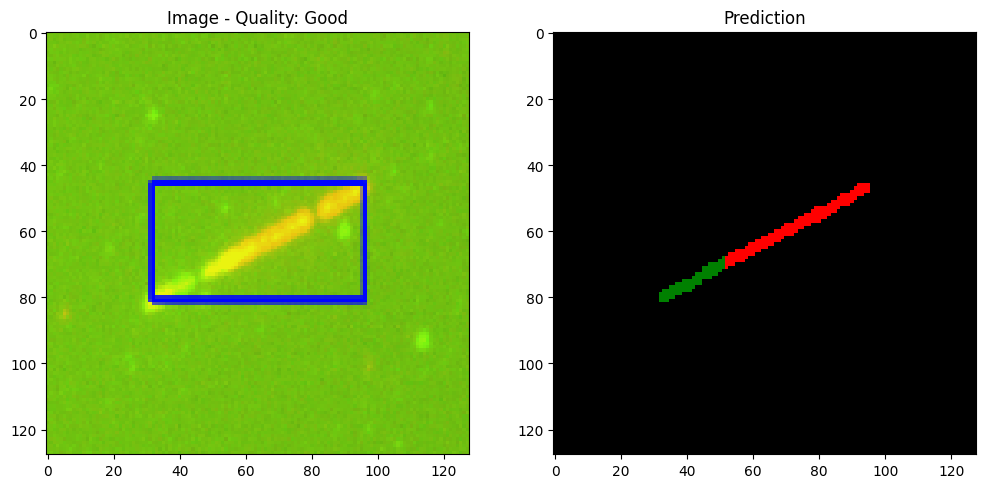

In [6]:
dataset.plot(0)